In [101]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import tensorflow_addons as tfa

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.7.0


In [115]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]
EPOCHS = 200

In [126]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [127]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

In [128]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [129]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

In [146]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40)

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Dropout, Resizing, Rescaling

In [120]:
IMG_SIZE = 227

resize_and_rescale = tf.keras.Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
  Rescaling(1./255)
])

In [130]:
model = Sequential(
    [
        Input(shape=(*IMAGE_SIZE, 3)),
        resize_and_rescale,
        Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        Conv2D(filters=256, kernel_size=(5,5), strides=(1,1),padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),padding='valid', activation='relu'),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),padding='valid', activation='relu'),
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        Flatten(),
        Dense(4096, input_shape=(227*227*3,) , activation='relu'),
        Dropout(0.4),
        Dense(4096, activation='relu'),
        Dropout(0.4),
        Dense(4, activation='softmax')
    ]
)

model.summary()

Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_131 (Sequential)  (None, 227, 227, 3)      0         
                                                                 
 conv2d_46 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_97 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_98 (MaxPoolin  (None, 11, 11, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 9, 9, 384)      

In [131]:
with strategy.scope():
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [133]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[lr_scheduler, my_callback],
    epochs=EPOCHS
)

Epoch 1/200
257/257 [==============================] - 11s 41ms/step - loss: 1.0416 - auc: 0.7796 - acc: 0.5004 - f1_score: 0.1681 - val_loss: 1.0396 - val_auc: 0.7767 - val_acc: 0.4951 - val_f1_score: 0.1656 - lr: 0.0100
Epoch 2/200
257/257 [==============================] - 4s 15ms/step - loss: 1.0385 - auc: 0.7802 - acc: 0.5011 - f1_score: 0.1672 - val_loss: 1.0398 - val_auc: 0.7767 - val_acc: 0.4951 - val_f1_score: 0.1656 - lr: 0.0089
Epoch 3/200
257/257 [==============================] - 4s 15ms/step - loss: 1.0395 - auc: 0.7790 - acc: 0.5013 - f1_score: 0.1673 - val_loss: 1.0397 - val_auc: 0.7767 - val_acc: 0.4951 - val_f1_score: 0.1656 - lr: 0.0079
Epoch 4/200
257/257 [==============================] - 4s 16ms/step - loss: 1.0382 - auc: 0.7796 - acc: 0.5011 - f1_score: 0.1669 - val_loss: 1.0399 - val_auc: 0.7767 - val_acc: 0.4951 - val_f1_score: 0.1656 - lr: 0.0071
Epoch 5/200
257/257 [==============================] - 4s 15ms/step - loss: 1.0379 - auc: 0.7803 - acc: 0.5011 - f1

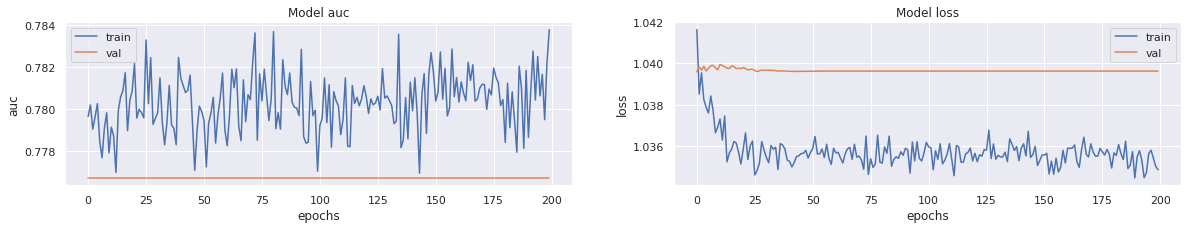

In [134]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [135]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode = 'int'
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [136]:
model.evaluate(test_ds)

80/80 [==============================] - 1s 9ms/step - loss: 1.0330 - auc: 0.7806 - acc: 0.5004 - f1_score: 0.1668


[1.0330214500427246,
 0.7805577516555786,
 0.5003909468650818,
 array([0.        , 0.        , 0.66701406, 0.        ], dtype=float32)]

## Avec augmentation des données 
### Sans SMOTE

In [139]:
from zipfile import ZipFile
file_name="Dataset_aug.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print("Done")

Done


In [141]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./Dataset_aug/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./Dataset_aug/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 8484 files belonging to 4 classes.
Using 6788 files for training.
Found 8484 files belonging to 4 classes.
Using 1696 files for validation.


In [142]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [148]:
model = Sequential(
    [
        Input(shape=(*IMAGE_SIZE, 3)),
        resize_and_rescale,
        Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        Conv2D(filters=256, kernel_size=(5,5), strides=(1,1),padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),padding='valid', activation='relu'),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),padding='valid', activation='relu'),
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),
        Flatten(),
        Dense(4096, input_shape=(227*227*3,) , activation='relu'),
        Dropout(0.4),
        Dense(4096, activation='relu'),
        Dropout(0.4),
        Dense(4, activation='softmax')
    ]
)

model.summary()

Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_131 (Sequential)  (None, 227, 227, 3)      0         
                                                                 
 conv2d_56 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 27, 27, 96)       0         
 ng2D)                                                           
                                                                 
 conv2d_57 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_104 (MaxPooli  (None, 11, 11, 256)      0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 9, 9, 384)      

In [149]:
with strategy.scope():
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [150]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[my_callback, early_stopping],
    epochs=EPOCHS
)

Epoch 1/200
425/425 [==============================] - 8s 16ms/step - loss: 1.3872 - auc: 0.5677 - acc: 0.2958 - f1_score: 0.1853 - val_loss: 1.3752 - val_auc: 0.5584 - val_acc: 0.3072 - val_f1_score: 0.1175
Epoch 2/200
425/425 [==============================] - 7s 16ms/step - loss: 1.3697 - auc: 0.5653 - acc: 0.2904 - f1_score: 0.1778 - val_loss: 1.3753 - val_auc: 0.5584 - val_acc: 0.3072 - val_f1_score: 0.1175
Epoch 3/200
425/425 [==============================] - 7s 16ms/step - loss: 1.3692 - auc: 0.5659 - acc: 0.2912 - f1_score: 0.1725 - val_loss: 1.3752 - val_auc: 0.5584 - val_acc: 0.3072 - val_f1_score: 0.1175
Epoch 4/200
425/425 [==============================] - 7s 16ms/step - loss: 1.3689 - auc: 0.5654 - acc: 0.2957 - f1_score: 0.1772 - val_loss: 1.3751 - val_auc: 0.5584 - val_acc: 0.3072 - val_f1_score: 0.1175
Epoch 5/200
425/425 [==============================] - 7s 16ms/step - loss: 1.3689 - auc: 0.5653 - acc: 0.2951 - f1_score: 0.1790 - val_loss: 1.3752 - val_auc: 0.5584 -

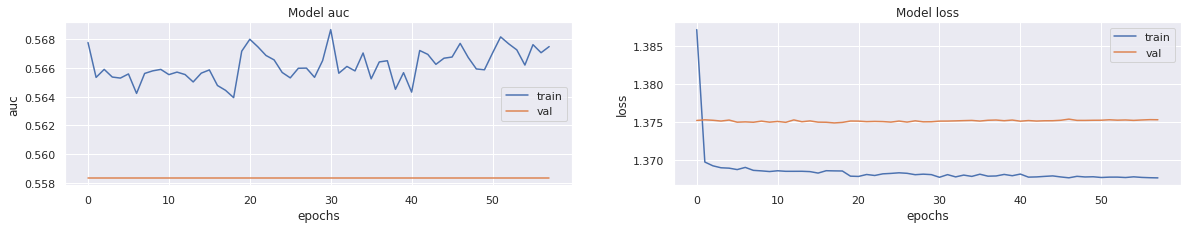

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [152]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./Dataset_aug/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode = 'int'
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [153]:
model.evaluate(test_ds)

80/80 [==============================] - 1s 8ms/step - loss: 1.2624 - auc: 0.7806 - acc: 0.5004 - f1_score: 0.1668


[1.262359619140625,
 0.7805577516555786,
 0.5003909468650818,
 array([0.        , 0.        , 0.66701406, 0.        ], dtype=float32)]

### Avec SMOTE

In [161]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

ImportError: cannot import name 'DistanceMetric' from 'sklearn.metrics' (/usr/local/lib/python3.8/dist-packages/sklearn/metrics/__init__.py)

In [ ]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)